In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
pd.set_option('display.max_columns',None)

<h3> 1. Importing Datasets</h3>

In [ ]:
#https://www.kaggle.com/datasets/joebeachcapital/top-1000-steam-games
df_description = pd.read_csv("../data/01_raw/prod_description.csv")
print(df_description.shape)
df_description.sample()

(83560, 40)


,Unnamed: 0,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
13376,13376,788640,Dungeon Stars,"Apr 26, 2018",0 - 20000,0,0,9.99,0,"Dungeon Stars is a mix of hack 'n' slash, RPG ...","['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://furnacegames.com,NaN,support@ripostegames.com,True,False,False,0,NaN,0,18,14,NaN,0,0,NaN,0,0,0,0,Furnace Games,Riposte Games & Co.,"Single-player,Partial Controller Support","Action,Adventure,Indie,RPG","Action,Adventure,RPG,Indie,Singleplayer,Fantas...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN


In [4]:
#https://www.kaggle.com/datasets/tamber/steam-video-games?resource=download
df_steam = pd.read_csv("../data/01_raw/steam-200k.csv"
    ,usecols=[0,1,2,3]
    ,names=['USER_ID','GAME_NAME','BEHAVIOR','GAMEPLAY_HOURS']
    )
print(df_steam.shape)
df_steam.sample()

(200000, 4)


,USER_ID,GAME_NAME,BEHAVIOR,GAMEPLAY_HOURS
32378,131785763,Happy Wars,purchase,1.0


<h3> 2. Pre processing</h3>

In [5]:
#Since the BEHAVIOR column is used for two purposes:
# - 1. Used to inform the total time spent for each user on its respective game
#       when the class is defined as "play";
# - 2. Used to inform if the user purchased the respective game
#However, this dataset contains only purchased games. Then this column is actually
#   used to inform if the user just bought the game and did not play.  

df_steam[df_steam.BEHAVIOR=='purchase'].GAMEPLAY_HOURS.unique()

array([1.])

In [6]:
#Feature-Eng: Droping BEHAVIOR column and setting to zero the GAMEPLAY_HOURS if 
#   the user purchased the game but did not spend time playing.

# Step-1: Grouping User-Game to identify users that didn't play yet.
df_purchase = df_steam.groupby(['USER_ID','GAME_NAME']).agg(
    FE_BEHAVIOR = ('BEHAVIOR','unique')
).reset_index()
df_purchase['FE_BEHAVIOR']=df_purchase.FE_BEHAVIOR.astype(str)

# Step-2: Filtering just users that played at least 1 hour on each game.
df_steam = df_steam[df_steam.BEHAVIOR=='play']

# Step-3: Filtering users that didn't play the game, and setting to zero
# the gameplay_hours columns for all users.
df_purchase = df_purchase[df_purchase.FE_BEHAVIOR=="['purchase']"]
df_purchase['GAMEPLAY_HOURS']=0
df_purchase = df_purchase[['USER_ID','GAME_NAME','GAMEPLAY_HOURS']]

# Step-4: Concatenating both dataframes
df_steam = pd.concat([df_steam,df_purchase])
df_steam.drop(columns='BEHAVIOR',inplace=True)
del df_purchase
print(df_steam.shape)
df_steam.sample()

(128816, 3)


,USER_ID,GAME_NAME,GAMEPLAY_HOURS
11078,16154372,Fallout New Vegas,0.0


In [7]:
df_description.rename(columns={'Name':'GAME_NAME'},inplace=True)
df_description.dropna(subset=['GAME_NAME'], inplace=True)
df_description['FK_GAME_NAME'] = df_description['GAME_NAME'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x))
df_description['FK_GAME_NAME'] = df_description['FK_GAME_NAME'].str.lower()
df_description.drop_duplicates(subset=['FK_GAME_NAME'],inplace=True)

df_steam['FK_GAME_NAME'] = df_steam['GAME_NAME'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x))
df_steam['FK_GAME_NAME'] = df_steam['FK_GAME_NAME'].str.lower()

df_steam = df_steam.merge(
    df_description.drop(columns='GAME_NAME')
    ,on='FK_GAME_NAME'
    ,how='inner'
    ,validate='m:1'
)

print(df_steam.shape[0])
df_steam.sample()

91803


,USER_ID,GAME_NAME,GAMEPLAY_HOURS,FK_GAME_NAME,Unnamed: 0,AppID,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
66387,38731746,Company of Heroes Tales of Valor,0.0,companyofheroestalesofvalor,49649,20540,"Apr 8, 2009",1000000 - 2000000,79,17,19.99,0,Company of Heroes®: Tales of Valor™ is the exp...,"['English', 'French', 'German', 'Italian', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.companyofheroesgame.com,https://support.sega.co.uk,NaN,True,False,False,70,https://www.metacritic.com/game/pc/company-of-...,0,1878,143,NaN,0,1340,NaN,1566,4,87,4,Relic Entertainment,SEGA,"Single-player,Multi-player,Steam Cloud",Strategy,"Strategy,World War II,RTS,Military,Multiplayer...",https://cdn.akamai.steamstatic.com/steam/apps/...,NaN


In [8]:
print(
    'Number of users: ',df_steam.USER_ID.nunique(),
    '\nMean purchases per user: ', round(df_steam.groupby('USER_ID').GAME_NAME.count().mean(),2),' Games',
    '\nMean time spent per game: ',round(df_steam.groupby(['USER_ID','GAME_NAME']).GAMEPLAY_HOURS.sum().mean(),2),' Hours',
    '\nMost purchased games: ',df_steam['GAME_NAME'].value_counts().reset_index().head()['GAME_NAME'].tolist(),
    '\nMost played games: ',df_steam.groupby(['GAME_NAME']).GAMEPLAY_HOURS.sum().reset_index().sort_values('GAMEPLAY_HOURS',ascending=False).head()['GAME_NAME'].tolist()
)

Number of users:  11463 
Mean purchases per user:  8.01  Games 
Mean time spent per game:  31.97  Hours 
Most purchased games:  ['Dota 2', 'Team Fortress 2', 'Unturned', 'Counter-Strike Global Offensive', 'Half-Life 2 Lost Coast'] 
Most played games:  ['Dota 2', 'Counter-Strike Global Offensive', 'Team Fortress 2', 'Counter-Strike', "Sid Meier's Civilization V"]


In [10]:
df_steam.to_parquet('../data/02_pre_proc/ABT_full.parquet')

<h3> 3. Feature engineering</h3>

In [11]:
df_steam = df_steam[['USER_ID', 'FK_GAME_NAME', 'GAMEPLAY_HOURS','Release date','Estimated owners', 'Peak CCU'
                     , 'Required age','Price', 'DLC count', 'About the game', 'Supported languages','Reviews', 'Windows'
                     , 'Mac', 'Linux', 'Metacritic score', 'User score', 'Positive','Negative', 'Score rank'
                     , 'Achievements', 'Recommendations', 'Notes','Categories', 'Genres', 'Tags']]

In [12]:
def parsing_date(date_string):
    for fmt in ('%b %d, %Y', '%b %d'):
        try:
            return pd.to_datetime(date_string, format=fmt)
        except ValueError:
            continue
    return pd.NaT  # Retorna NaT (Not a Time) se nenhum formato funcionar

# Aplicação da função à série
df_steam['Release date'] = df_steam['Release date'].apply(parsing_date)
df_steam['Release date'] = pd.Timestamp('now') - df_steam['Release date'] 
df_steam['Release date'] = df_steam['Release date'].dt.days
df_steam.rename(columns={'Release date':'release_from_now'},inplace=True)


C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\690964952.py:4: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  return pd.to_datetime(date_string, format=fmt)
C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\690964952.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steam['Release date'] = df_steam['Release date'].apply(parsing_date)
C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\690964952.py:11: Setti

In [13]:
# Função para extrair e converter os números
def extract_and_convert(s):
    parts = s.split('-')
    num1 = int(parts[0])
    num2 = int(parts[1])
    mean = (num1 + num2)/2
    return mean

df_steam['Estimated owners'] = df_steam['Estimated owners'].apply(lambda x: extract_and_convert(x))

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\3548091452.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steam['Estimated owners'] = df_steam['Estimated owners'].apply(lambda x: extract_and_convert(x))


In [14]:
rules_features = ['Required age','Windows','Mac','Linux']
df_steam.drop(columns=rules_features,inplace=True)

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\1805842996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steam.drop(columns=rules_features,inplace=True)


C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_steam['Score rank'].fillna(0,inplace=True)
C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steam['Score rank'].fillna(0,inplace=True)
C:\Users\rena

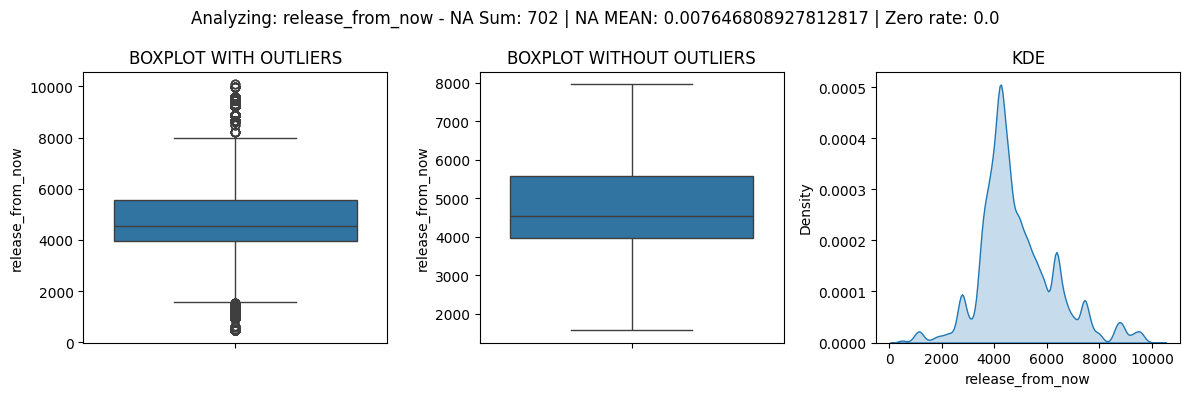

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[col], ax=axes[2], shade=True)


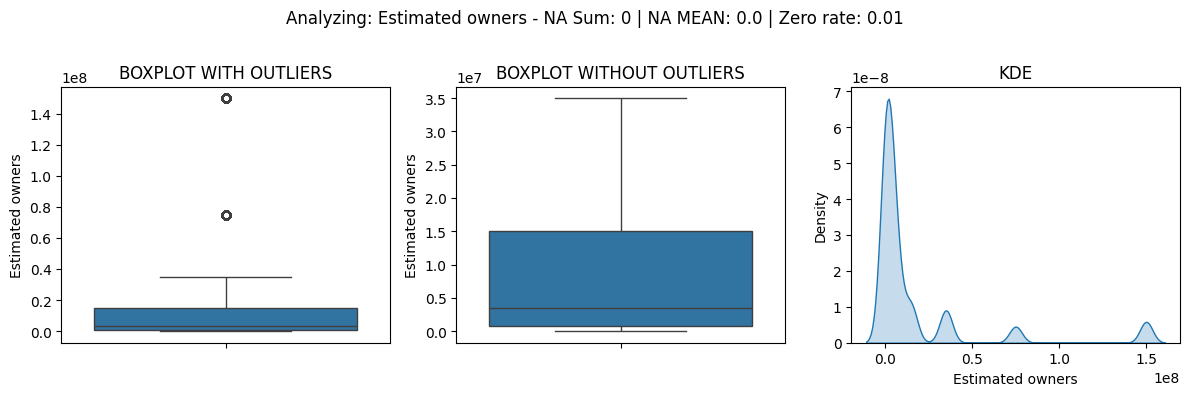

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[col], ax=axes[2], shade=True)


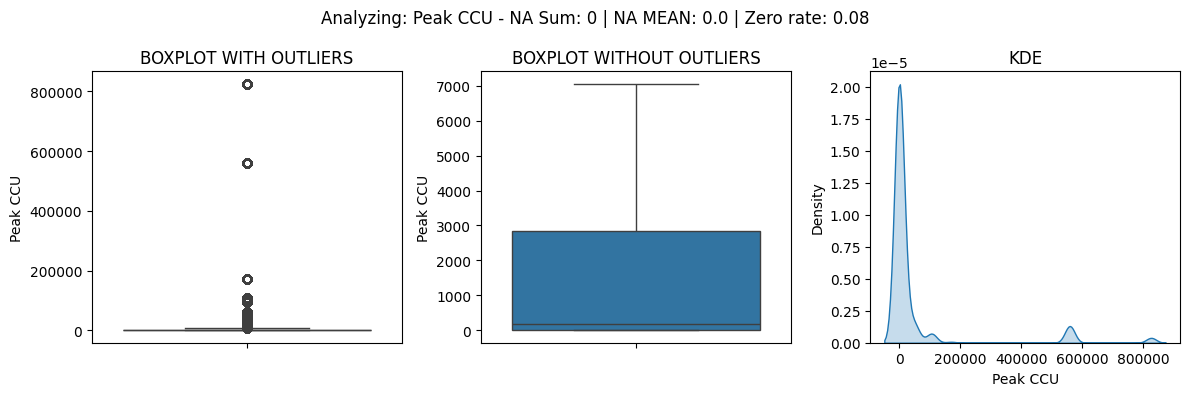

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[col], ax=axes[2], shade=True)


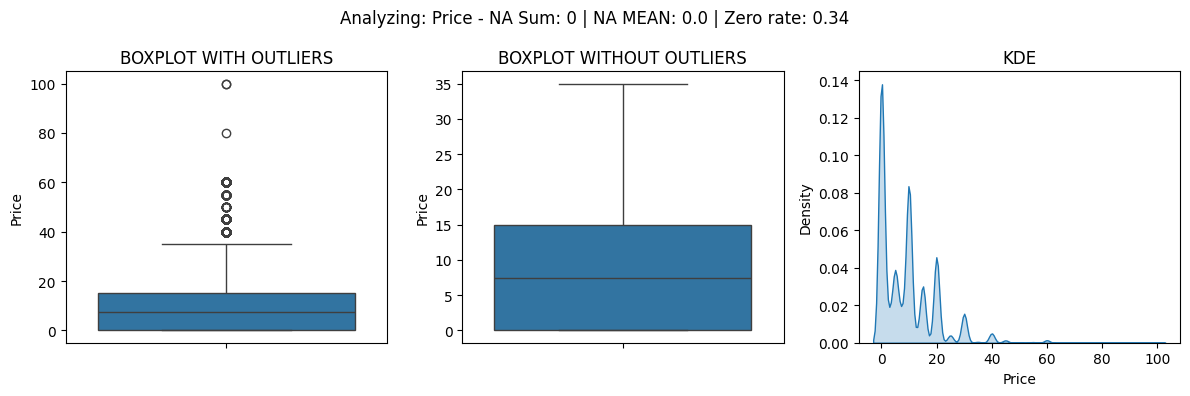

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[col], ax=axes[2], shade=True)


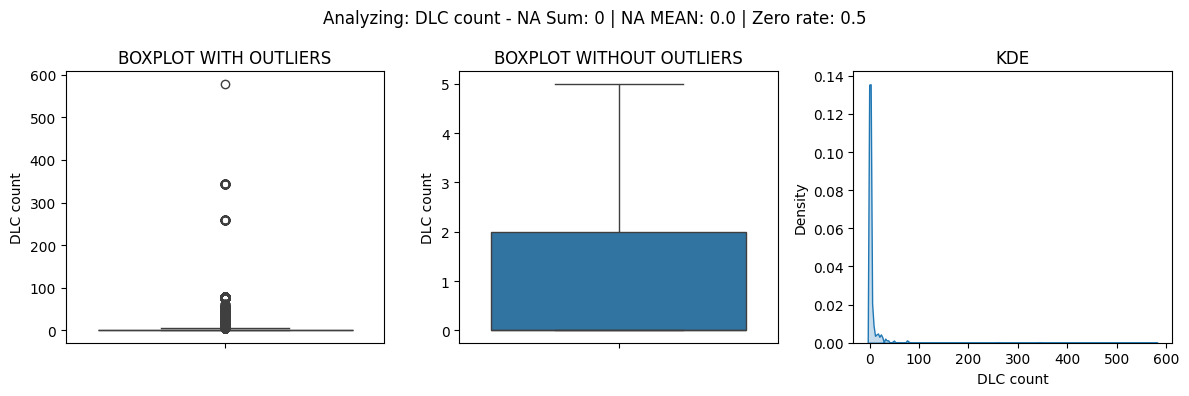

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[col], ax=axes[2], shade=True)


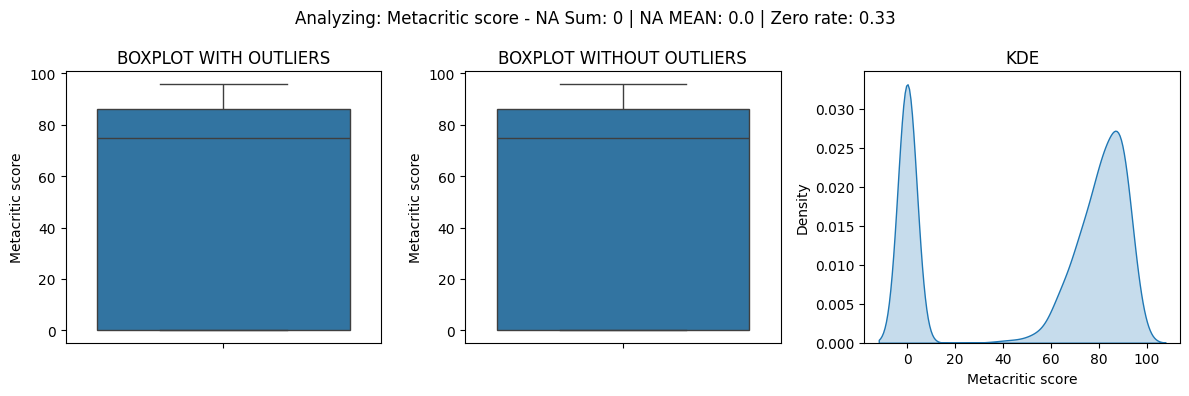

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[col], ax=axes[2], shade=True)
C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data[col], ax=axes[2], shade=True)


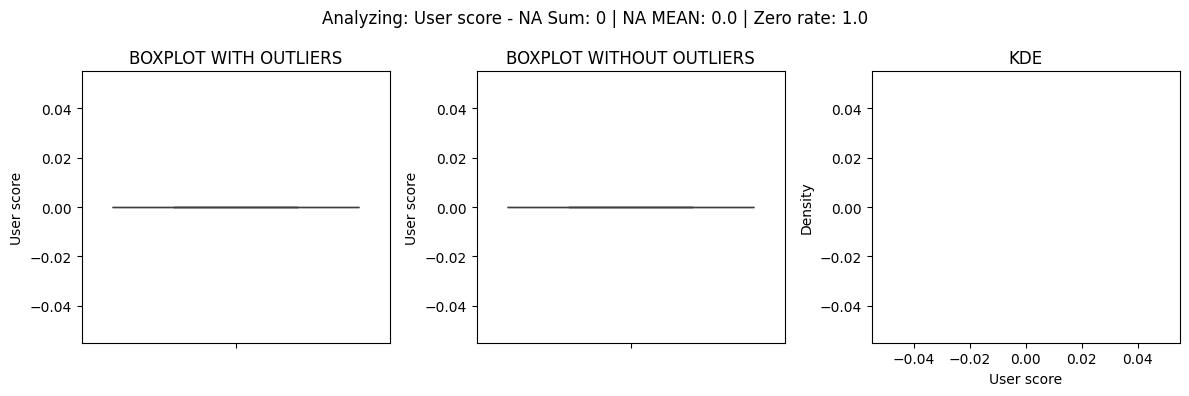

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[col], ax=axes[2], shade=True)


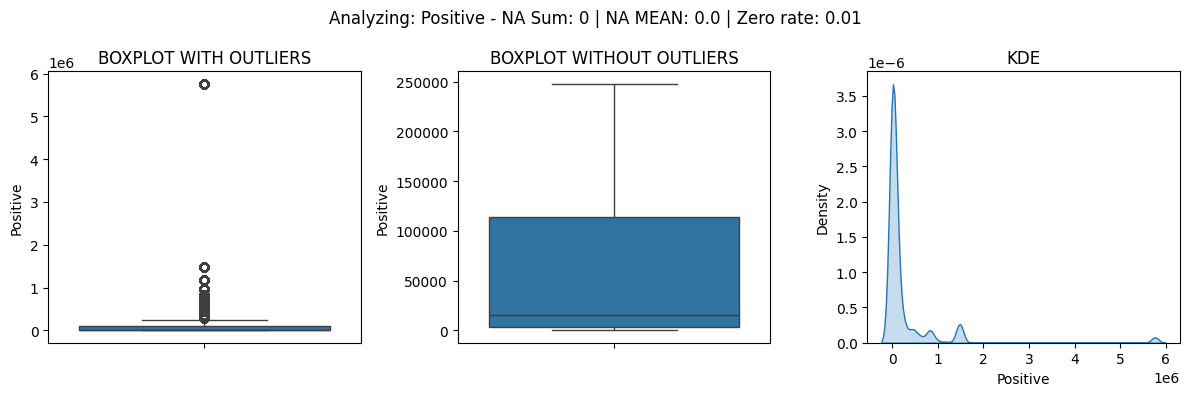

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[col], ax=axes[2], shade=True)


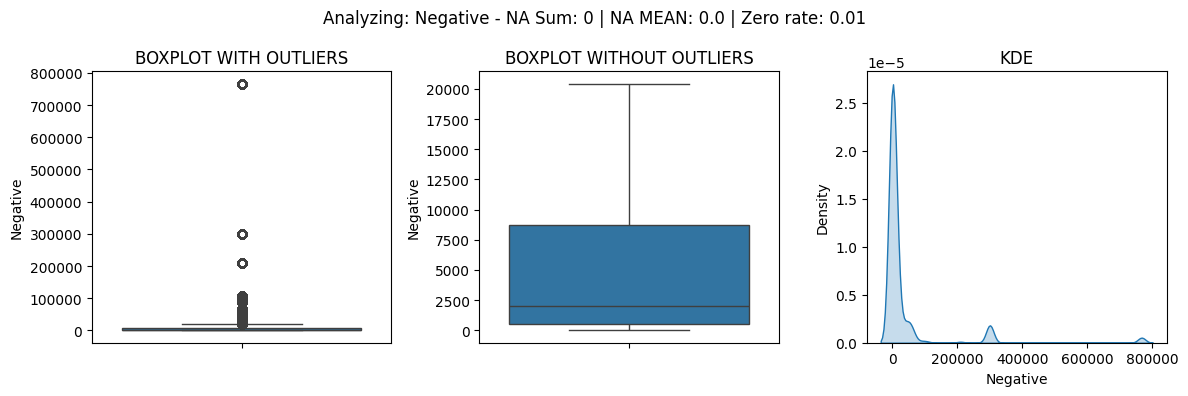

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[col], ax=axes[2], shade=True)


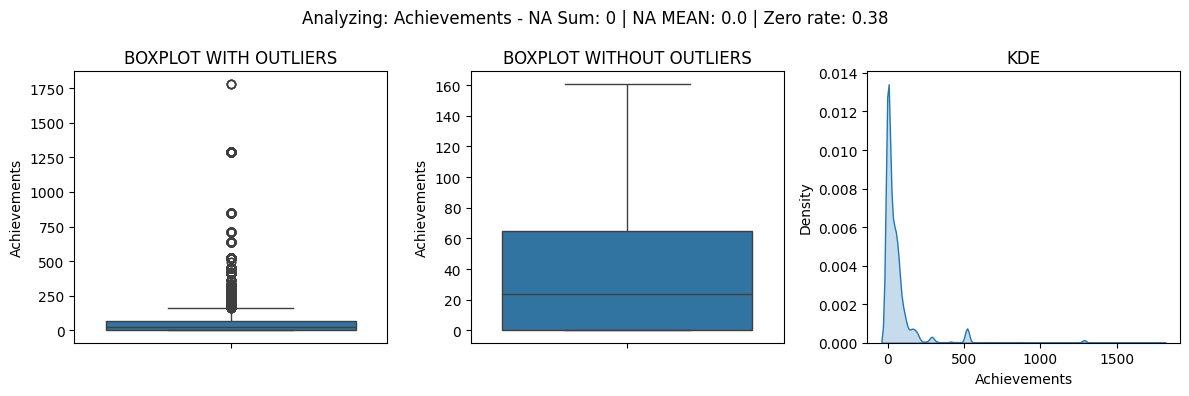

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[col], ax=axes[2], shade=True)


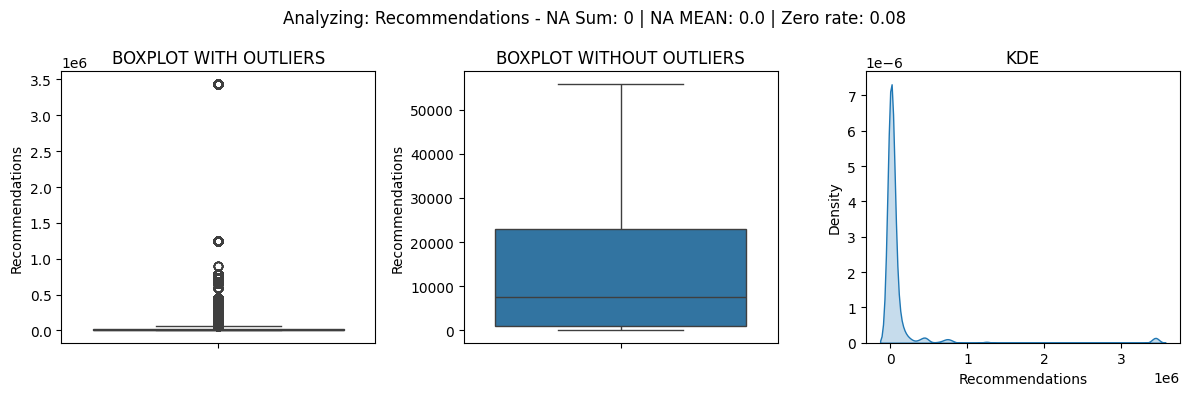

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[col], ax=axes[2], shade=True)
C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\2181248637.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data[col], ax=axes[2], shade=True)


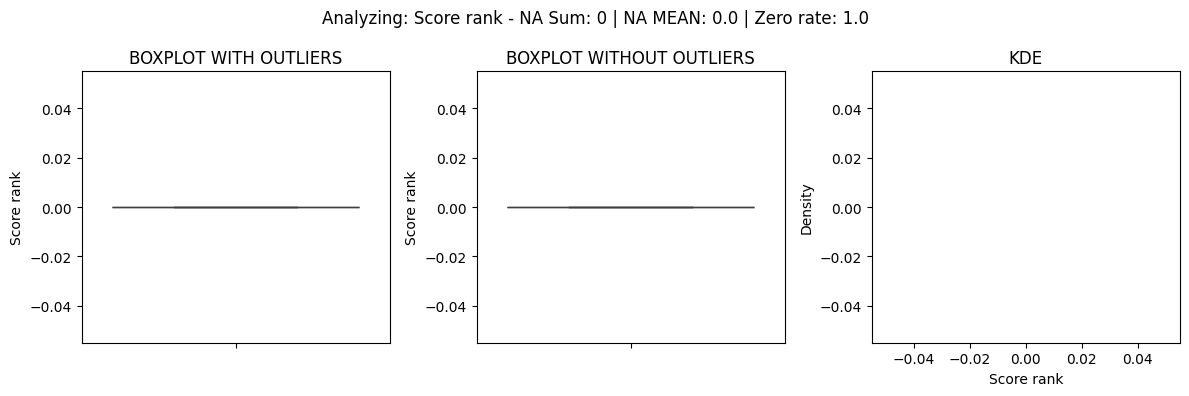

In [15]:
def analyze_series(data, col):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    sns.boxplot(data=data[col], ax=axes[0])
    axes[0].set_title(f"BOXPLOT WITH OUTLIERS")
    
    sns.boxplot(data=data[col], ax=axes[1],showfliers=False)
    axes[1].set_title(f"BOXPLOT WITHOUT OUTLIERS")
    
    sns.kdeplot(data=data[col], ax=axes[2], shade=True)
    axes[2].set_title(f"KDE")
    
    fig.suptitle(
        f"Analyzing: {col} - NA Sum: {data[col].isna().sum()} | NA MEAN: {data[col].isna().mean()} | Zero rate: {round(data[data[col]==0].shape[0]/data.shape[0],2)}"
        , fontsize=12)
    plt.tight_layout()
    plt.show()


df_steam['Score rank'].fillna(0,inplace=True)
feat_analysis =\
    ['release_from_now','Estimated owners','Peak CCU'
     ,'Price','DLC count','Metacritic score','User score'
     ,'Positive','Negative','Achievements','Recommendations'
     ,'Score rank']
for i in feat_analysis:
    analyze_series(df_steam, i)

In [16]:
#Relationship between NULLs on Negative and Positive features 
#Does not seem to have a relationship
gb_neg_pos=df_steam[['Negative','Positive']].copy()
gb_neg_pos['Negative'] = pd.Series(np.where(df_steam.Negative==0,0,1))
gb_neg_pos['Positive'] = pd.Series(np.where(df_steam.Positive==0,0,1))
gb_neg_pos['counter'] = 1
gb_neg_pos.groupby(['Negative','Positive']).counter.count().reset_index()

,Negative,Positive,counter
0,0,0,656
1,0,1,96
2,1,0,87
3,1,1,90964


In [17]:
#dropar metacritict, user score, score rank, Negative, Positive
misfit_features = ['Metacritic score', 'User score','Positive', 'Negative', 'Score rank']
df_steam.drop(columns=misfit_features,inplace=True)
df_steam.sample()

C:\Users\renan.vital\AppData\Local\Temp\ipykernel_22140\1036991874.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_steam.drop(columns=misfit_features,inplace=True)


,USER_ID,FK_GAME_NAME,GAMEPLAY_HOURS,release_from_now,Estimated owners,Peak CCU,Price,DLC count,About the game,Supported languages,Reviews,Achievements,Recommendations,Notes,Categories,Genres,Tags
39,59945701,companyofheroesopposingfronts,0.1,6362.0,1500000.0,52,19.99,0,The next chapter in the #1 rated RTS franchise...,['English'],NaN,0,608,NaN,"Single-player,Multi-player,Steam Cloud","Action,Strategy","Strategy,RTS,World War II,Action,Singleplayer,..."


In [19]:
df_steam.to_parquet('../data/02_pre_proc/ABT_feats.parquet')